<a href="https://colab.research.google.com/github/edborgesfh/the_bassIR/blob/main/the_bassIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# the_bassIR
um script que simplifica a visualização do seu audio com o IR

1) Abra esse arquivo em seu notebook do Google Colab

2) Carregue seu arquivo de áudio e seu IR em arquivos no painel laterial do Colab

3) Vá até a linha de código
audio_path = '/content/groove_1.wav'
e substitua groove_1 pelo nome do seu arquivo

4) Vá até a linha de código
ir_path = '/content/ir_1.wav'
e substitua ir_1 pelo nome do seu IR

5) Execute as linhas de todos os códigos do script

6) Veja!

# Instalações e carregamento dos elementos

In [34]:
!pip install -q -U sounddevice
!pip install -q -U soundfile
!pip install -q -U librosa
!pip install -q -U matplotlib
!pip install -q -U scipy

!sudo apt-get install -q -U libportaudio2

In [37]:
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import Audio

import sounddevice as sd
from scipy.io.wavfile import write

import scipy.signal as signal

# Funções iniciais

In [12]:
# Função para carregar o áudio
def load_audio(file_path):
    y, sr = librosa.load(file_path)
    return y, sr

In [13]:
# Função para plotar o espectrograma
def plot_spectrogram(y, sr):
    D = librosa.stft(y)
    Sdb = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(Sdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(label='dB')
    plt.title('Espectrograma')
    plt.tight_layout()
    plt.show()

In [52]:
# Função para plotar o SPL (Sound Pressure Level)
def plot_spl_frequency(y, sr):
    # Calcula a STFT (Short-Time Fourier Transform)
    stft = librosa.stft(y)

    # Calcula a magnitude da STFT
    magnitude = np.abs(stft)

    # Converte a magnitude para dB
    db = librosa.amplitude_to_db(magnitude, ref=np.max)

    # Obtem as frequencias correspondentes a cada linha da STFT
    # Correction: Use the correct n_fft value to match the STFT dimensions
    frequencies = librosa.fft_frequencies(sr=sr, n_fft=stft.shape[0])

    # Encontra o dB máximo para cada frequência
    max_db_per_frequency = np.max(db, axis=1)

    # Before plotting, ensure frequencies and max_db_per_frequency have the same length
    # If not, trim the longer array to match the shorter one
    min_len = min(len(frequencies), len(max_db_per_frequency))
    frequencies = frequencies[:min_len]
    max_db_per_frequency = max_db_per_frequency[:min_len]

    freq_ticks = [20, 50, 70, 100, 150, 250, 500, 1000, 1500, 2000, 3000, 5000, 10000, 15000, 20000]

    # Função para formatar os labels de frequência
    def format_freq_labels(freq):
        if freq >= 1000:
            return f"{freq/1000:.1f}k" if freq % 1000 != 0 else f"{int(freq/1000)}k" # Formatação condicional
        else:
            return str(freq)

    # Aplica a função de formatação aos ticks
    freq_labels = [format_freq_labels(f) for f in freq_ticks]

    plt.figure(figsize=(10, 4))
    plt.plot(frequencies, max_db_per_frequency)

    plt.xlabel('Frequência (Hz)')
    plt.ylabel('SPL Máximo (dB)')
    plt.title('SPL Máximo por Frequência')

    plt.xscale('log')
    plt.xticks(freq_ticks, freq_labels)
    plt.tight_layout()
    plt.show()

In [53]:
# Função para exibir o audio player
def display_audio_player(audio_data, sr=None):  # Add sr as an optional argument
    """Displays an audio player.

    Args:
        audio_data: The audio data to play.
        sr: The sample rate of the audio data (optional).
    """
    # If sr is provided, assume audio_data is a NumPy array and create an Audio object
    # with the specified rate
    if sr is not None:
        return Audio(audio_data, rate=sr)
    # Otherwise, assume audio_data is a file path and pass it directly to Audio
    else:
        return Audio(audio_data)

## Elementos visuais

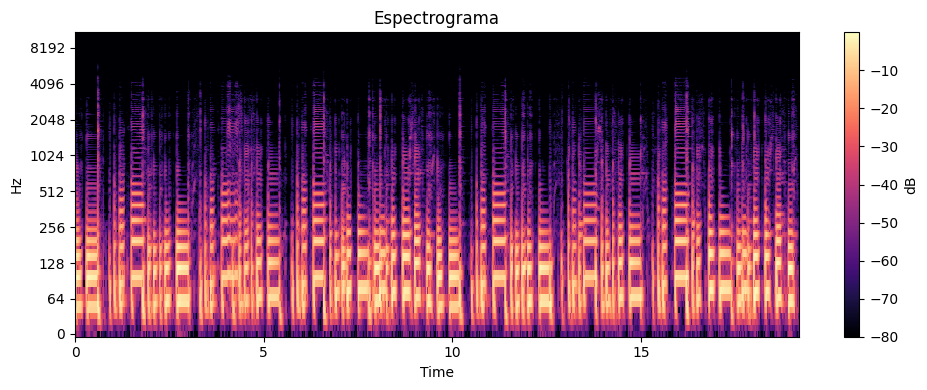

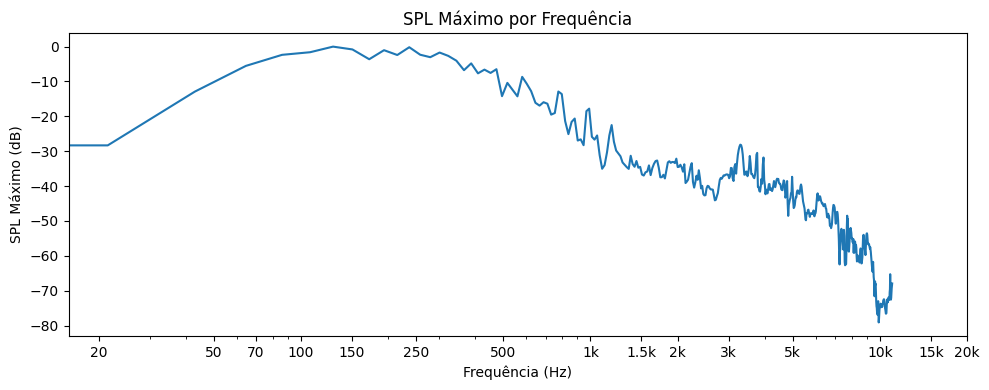

In [55]:
audio_path = '/content/groove_1.wav' # Substitua pelo caminho do seu arquivo

# Carrega o áudio
y, sr = load_audio(audio_path)


# Plota o espectrograma
plot_spectrogram(y, sr)

# Plota o SPL
plot_spl_frequency(y, sr)

# Exibe o audio player
display_audio_player(audio_path)

# Funções com IR

In [46]:
# Carregar e aplicar o IR
def apply_impulse_response_and_normalize(audio, sr, ir_path):
    # Carrega a resposta ao impulso
    ir, sr_ir = librosa.load(ir_path, sr=sr)  # Garante a mesma taxa de amostragem

    # Convolução: aplica a resposta ao impulso
    audio_ir = signal.convolve(audio, ir, mode='full')

    # Normalização
    audio_ir_normalized = librosa.util.normalize(audio_ir)

    return audio_ir_normalized, sr

In [58]:
#Novo gráfico de SPL com IR
def plot_spl_frequency_with_ir(y, sr, y_ir):
    # Calcula a STFT para o áudio original e o áudio com IR
    stft = librosa.stft(y)
    stft_ir = librosa.stft(y_ir)

    # Calcula a magnitude da STFT
    magnitude = np.abs(stft)
    magnitude_ir = np.abs(stft_ir)

    # Converte a magnitude para dB
    db = librosa.amplitude_to_db(magnitude, ref=np.max)
    db_ir = librosa.amplitude_to_db(magnitude_ir, ref=np.max)

    # Obtem as frequencias para o áudio original
    frequencies = librosa.fft_frequencies(sr=sr, n_fft=stft.shape[0])
    # Obtem as frequencias para o áudio com IR - using stft_ir.shape[0] now
    frequencies_ir = librosa.fft_frequencies(sr=sr, n_fft=stft_ir.shape[0])

    # Encontra o dB máximo para cada frequência
    max_db_per_frequency = np.max(db, axis=1)
    max_db_per_frequency_ir = np.max(db_ir, axis=1)

    # Before plotting, ensure frequencies and max_db_per_frequency have the same length
    # If not, trim the longer array to match the shorter one
    min_len = min(len(frequencies), len(max_db_per_frequency))
    frequencies = frequencies[:min_len]
    max_db_per_frequency = max_db_per_frequency[:min_len]

    # Before plotting, ensure frequencies_ir and max_db_per_frequency_ir have the same length
    # If not, trim the longer array to match the shorter one
    min_len_ir = min(len(frequencies_ir), len(max_db_per_frequency_ir))
    frequencies_ir = frequencies_ir[:min_len_ir]
    max_db_per_frequency_ir = max_db_per_frequency_ir[:min_len_ir]

    # Frequências para os ticks
    freq_ticks = [20, 50, 70, 100, 150, 250, 500, 1000, 1500, 2000, 3000, 5000, 10000, 15000, 20000]

    # Função para formatar os labels de frequência
    def format_freq_labels(freq):
        if freq >= 1000:
            return f"{freq/1000:.1f}k" if freq % 1000 != 0 else f"{int(freq/1000)}k" # Formatação condicional
        else:
            return str(freq)

    # Aplica a função de formatação aos ticks
    freq_labels = [format_freq_labels(f) for f in freq_ticks]

    plt.figure(figsize=(10, 4))
    plt.plot(frequencies, max_db_per_frequency, label='Original')
    # Use frequencies_ir for plotting audio_ir data
    plt.plot(frequencies_ir, max_db_per_frequency_ir, label='Com IR')

    plt.xlabel('Frequência (Hz)')
    plt.ylabel('SPL Máximo (dB)')
    plt.title('SPL Máximo por Frequência')

    plt.xscale('log')
    plt.xlim(20, 20000)
    plt.xticks(freq_ticks, freq_labels)

    plt.legend()  # Adiciona uma legenda para distinguir as linhas
    plt.tight_layout()
    plt.show()

## Elementos visuais com IR

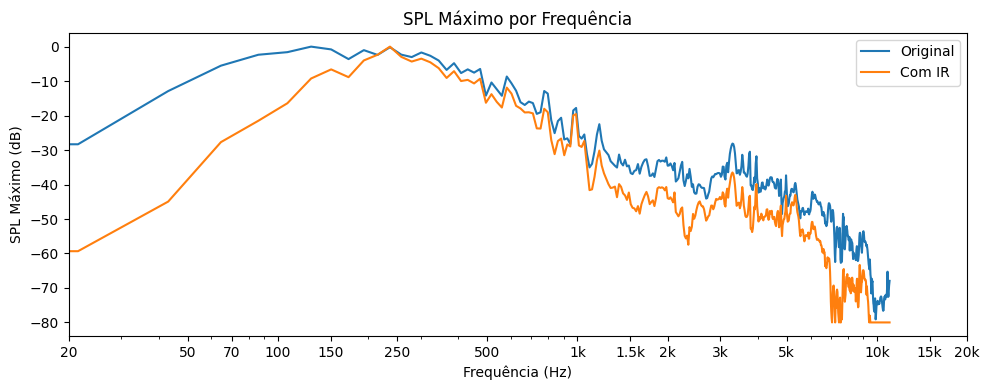

In [59]:
# Caminho para o arquivo de resposta ao impulso
ir_path = '/content/ir_1.wav'  # Substitua pelo caminho do seu arquivo IR

# Aplica a resposta ao impulso e normaliza
audio_ir, sr_ir = apply_impulse_response_and_normalize(y, sr, ir_path)


# Plota o SPL com a resposta ao impulso
plot_spl_frequency_with_ir(y, sr, audio_ir)

# Exibe o audio player para o áudio com IR
display_audio_player(audio_ir, sr=sr_ir) # É importante passar a taxa de amostragem!